In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import poisson_hypergraph
import xgi
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

# Define functions

In [2]:
def generate_graph(true_theta, timesteps):
    true_p, true_q, gamma_nu, gamma_nr, gamma_eu, gamma_er = true_theta
    H = xgi.Hypergraph([[0, 1, 2, 3]])
    H.set_node_attributes({0 : 0, 1 : 1, 2 : 1, 3 : 0}, name = "label")
    GH = poisson_hypergraph.GH(H, [0, 1], true_p, true_q)
    GH.add_hyperedge(timesteps, gamma_nu, gamma_nr, gamma_eu, gamma_er)
    return GH

In [3]:
def e_prime_prob(GH, e_prime_index, theta):
    edges = GH.get_edges()
    e_prime = edges[e_prime_index]
    summation = 0
    for e_index in range(e_prime_index):
        e = edges[e_index]
        for u_index in (e and e_prime):
            summation += GH.likelihood(e_index, u_index, e_prime_index, theta)
    return summation

In [4]:
def p_q_likelihoods(GH, grain, gammas):
    edges = GH.get_edges()

    gamma_nu, gamma_nr, gamma_eu, gamma_er = gammas

    P = np.linspace(0, 1, num = grain)
    Q = np.linspace(0, 1, num = grain)
    
    likelihood_values = np.zeros((grain, grain))

    for p_index, p in enumerate(P):
        for q_index, q in enumerate(Q):
            theta = [p, q, gamma_nu, gamma_nr, gamma_eu, gamma_er]
            this_likelihood = 0
            for e_prime_index in range(1, len(edges)):
                this_likelihood += np.log(e_prime_prob(GH, e_prime_index, theta))
            likelihood_values[q_index, p_index] = this_likelihood
    
    q_max, p_max = np.unravel_index(np.argmax(likelihood_values, axis=None), likelihood_values.shape)
    
    return likelihood_values, p_max, q_max

In [5]:
def make_plot(lik_values, p_max, q_max):

    
    bins = lik_values.shape[0]
    
    P = np.linspace(0, 1, num = bins)
    Q = np.linspace(0, 1, num = bins)

    fig4,ax4 = plt.subplots(1,1)
    cmap = cm['hot']
    cmap.set_bad('black',1.)
    img = plt.imshow(lik_values, cmap=cmap, interpolation='nearest', origin = "lower")
    ax4.set_xticks(ticks = np.linspace(0, 1, 11)*bins, labels = np.round(np.linspace(0, 1, 11), 2))
    ax4.set_yticks(ticks = np.linspace(0, 1, 11)*bins, labels = np.round(np.linspace(0, 1, 11), 2))
    # ax4.set_yticks(ticks = np.linspace(0, 1, 10), labels = np.linspace(0, 1, 10))
    # ax4.set_xticks(list(range(0, grain - 1, step)))
    # ax4.set_yticks(list(range(0, grain - 1, step)))
    # ax4.set_xticklabels([.1, .2, .3, .4, .5, .6, .7, .8, .9], rotation=90)
    # ax4.set_yticklabels([.1, .2, .3, .4, .5, .6, .7, .8, .9])
    ax4.set_xlabel("p")
    ax4.set_ylabel("q")
    ax4.scatter([p_max], [q_max], zorder = 100, color = "white", edgecolors="black")
    plt.colorbar()
    
    ax4.set_title(r"$\hat{p} = $" + f"{P[p_max]:.2f}" + "  |  " r"$\hat{q} = $" + f"{Q[q_max]:.2f}")
    
    
    
    
    
    plt.show()
    
    
    

In [6]:
def experiment(true_p, true_q, timesteps, grain):
    gamma_nu, gamma_nr, gamma_eu, gamma_er = 0.75, 0.25, 0.75, 0.25
    true_theta = [true_p, true_q, gamma_nu, gamma_nr, gamma_eu, gamma_er]
    GH = generate_graph(true_theta, timesteps)

    lik_values, p_max, q_max = p_q_likelihoods(GH, grain, [gamma_nu, gamma_nr, gamma_eu, gamma_er])

    return(GH, lik_values, p_max, q_max)

# Experiment Highlighting a Bug

In this experiment, we add just a single edge to the hypergraph, which we then inspect:

/var/folders/xn/wvbwvw0d6dx46h9_2bkrknnw0000gn/T/ipykernel_81218/3284248317.py:16: RuntimeWarning: divide by zero encountered in log
  this_likelihood += np.log(e_prime_prob(GH, e_prime_index, theta))


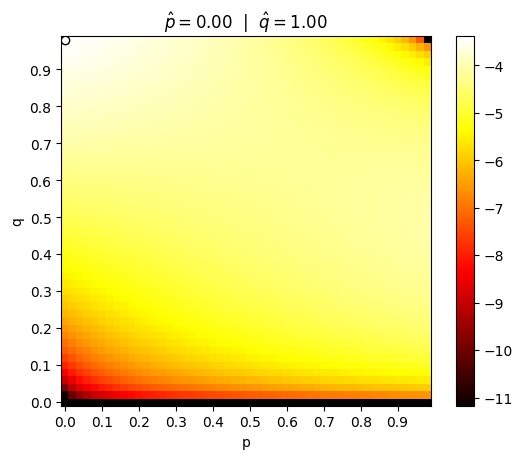

In [25]:
GH, lik_values, p_max, q_max = experiment(0.4, 0.4, 1, 50)
make_plot(lik_values, p_max, q_max)

In [26]:
GH.get_edges()

[{0, 1, 2, 3}, {0, 1, 3}]

The estimate of $p$ appears to be off. We should have some probability of sampling a node whose label agrees with $u$; for example, if $u = 1$ in this toy scenario, we could have sampled the $3$ through the process governed by $p$. 